# Model Test
Let's see how our model performs on the stage 1 test set.

## Imports
`pneumonia.model_test` has all the necessary functions.

In [1]:
import sys
sys.path.append("..")
from pneumonia.model_test import *

## Load the label map
This simply maps a class id to a human readable name, in our case 1 => pneumonia

In [2]:
LABEL_MAP = 'pneumonia/data/pneumonia_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP, use_display_name=True)

## Load the model

In [3]:
FROZEN_GRAPH = 'pneumonia/models/ssd_mobilenet_v2/exported/trained-10-07-2018/frozen-overriden/frozen_inference_graph.pb'
frozen_graph = load_tf_graph(FROZEN_GRAPH)

## Gather the test images

In [4]:
TEST_DIR = 'pneumonia/data/stage_1_test_images'
test_images = glob.glob(os.path.join(TEST_DIR, '*.dcm'))

## Run the test
Detect pneumonia opacities from the test images. Display the top 3 boxes (as long as their scores are above 0.0001). All the images will be saved in `OUPUT_DIR`. The first five images will be displayed below.

/home/keunwoo/Projects/yukw777-tf-models/research/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
100%|██████████| 125/125 [03:32<00:00,  1.64s/it]


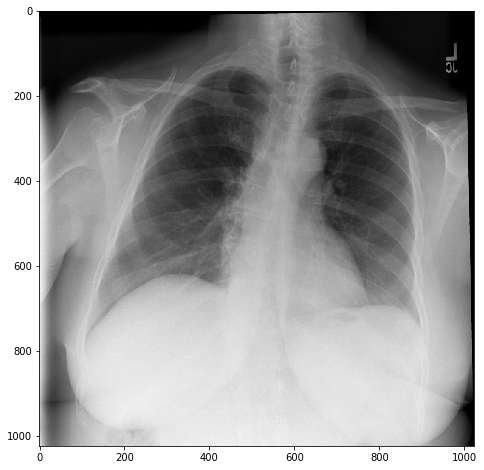

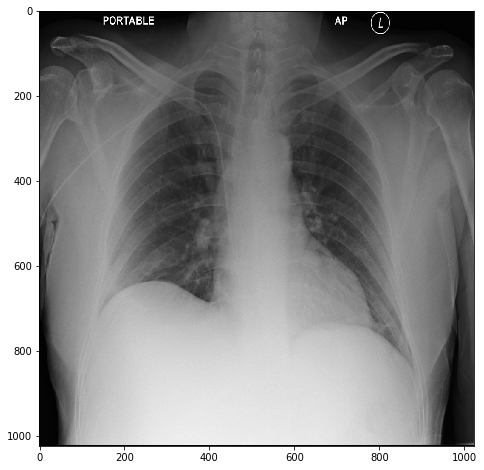

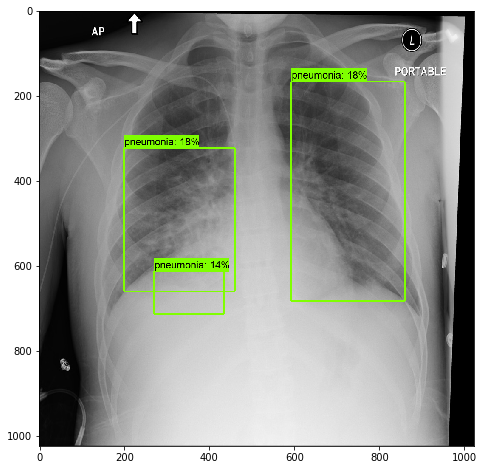

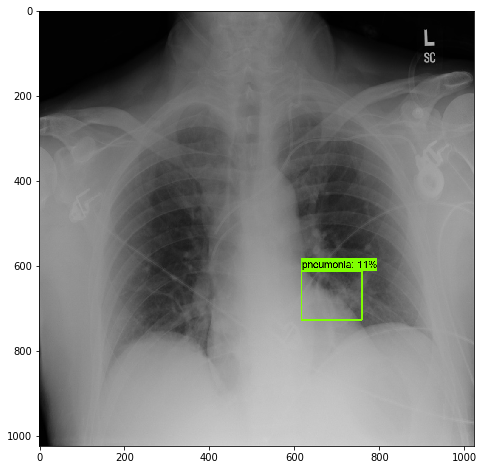

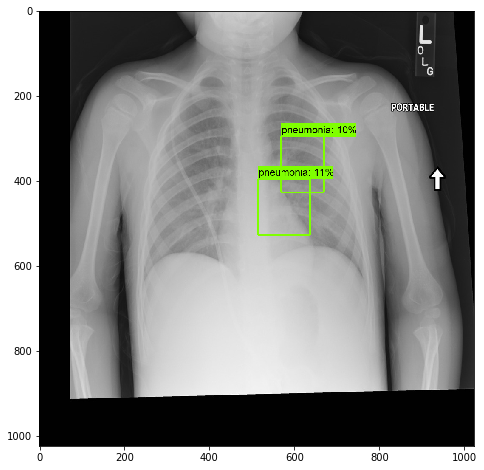

In [5]:
%matplotlib inline
from tqdm import tqdm
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
from PIL import Image

count = 0
OUPUT_DIR = 'pneumonia/models/ssd_mobilenet_v2/tested_images'
BATCH_SIZE = 8
if not os.path.exists(OUPUT_DIR):
    os.mkdir(OUPUT_DIR)

for batch in tqdm(batchify(test_images, BATCH_SIZE)):
    image_nps = []
    for image in batch:
        dcm = pydicom.read_file(image)
        image_nps.append(load_dcm_into_numpy_array(dcm))
    output = run_inference_for_image_batch(np.stack(image_nps), frozen_graph)
    for i in range(BATCH_SIZE):
        instance_masks = output.get('detection_masks')
        if instance_masks:
            instance_masks = instance_masks[i]
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_nps[i],
            output['detection_boxes'][i],
            output['detection_classes'][i],
            output['detection_scores'][i],
            category_index,
            instance_masks=instance_masks,
            use_normalized_coordinates=True,
            max_boxes_to_draw=3,
            min_score_thresh=0.0001
        )
    for image_np, image in zip(image_nps, batch):
        im = Image.fromarray(image_np)
        im.save(os.path.join(OUPUT_DIR, os.path.splitext(os.path.basename(image))[0] + '.jpg'))
    # show first 5 images with boxes
    for image_np in image_nps:
        if count >= 5:
            break
        plt.figure(figsize=(12, 8))
        plt.imshow(image_np)
        count += 1